In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.utils import shuffle
import statsmodels.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Load Dataset with all columns
# Making the data columns datetime objects with the parse_dates attribute
bikeshare_machine = pd.read_csv('/Users/matthewcassi/Documents/Bike-Sharing-Dataset/less_bikeshare_lat_lon.csv', 
                        parse_dates=['Start date', 'End date', 'start_date_short', 'end_date_short'])
# Removing the Unnamed column
bikeshare_machine.drop('Unnamed: 0', 1, inplace=True)

In [4]:
# creating a list of columns which will be used to create the list of columns to keep for the machine
# learning piece
list(bikeshare_machine.columns)

['Start date',
 'End date',
 'start_station',
 'start_station_code',
 'end_station',
 'end_station_code',
 'Member Type',
 'start_date_short',
 'end_date_short',
 'time_diff',
 'season',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'hum',
 'windspeed',
 'start_lat',
 'start_lon',
 'end_lat',
 'end_lon',
 'miles']

In [5]:
# Selecting the columns that are needed for the analysis
included_cols = ['start_station',
                 'end_station',
                 'Member Type',
                 'time_diff',
                 'season',
                 'mnth',
                 'holiday',
                 'weekday',
                 'workingday',
                 'weathersit',
                 'temp',
                 'hum',
                 'windspeed',
                 'miles']
# Subsetting the dataset so that only the columns above are included
bikeshare_machine = bikeshare_machine[included_cols]
bikeshare_machine.head()

,start_station,end_station,Member Type,time_diff,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,miles
0,14th & Harvard St NW,16th & Harvard St NW,Registered,1.833,2,3,0,4,1,3,0.268333,0.918333,0.217646,0.238743
1,Lincoln Park / 13th & East Capitol St NE,13th & H St NE,Registered,3.317,2,3,0,4,1,3,0.268333,0.918333,0.217646,0.659533
2,14th & R St NW,Massachusetts Ave & Dupont Circle NW,Registered,5.733,2,3,0,4,1,3,0.268333,0.918333,0.217646,0.691996
3,Park Rd & Holmead Pl NW,15th & P St NW,Registered,8.700,2,3,0,4,1,3,0.268333,0.918333,0.217646,1.453796
4,37th & O St NW / Georgetown University,21st & M St NW,Registered,7.850,2,3,0,4,1,3,0.268333,0.918333,0.217646,1.351053


In [6]:
# Make categorical data for columns like month, holiday, etc.
bikeshare_machine['season'] = bikeshare_machine['season'].astype('category')
bikeshare_machine['mnth'] = bikeshare_machine['mnth'].astype('category')
bikeshare_machine['holiday'] = bikeshare_machine['holiday'].astype('category')
bikeshare_machine['weekday'] = bikeshare_machine['weekday'].astype('category')
bikeshare_machine['workingday'] = bikeshare_machine['workingday'].astype('category')
bikeshare_machine['weathersit'] = bikeshare_machine['weathersit'].astype('category')
bikeshare_machine['Member Type'] = bikeshare_machine['Member Type'].astype('category')
bikeshare_machine['start_station'] = bikeshare_machine['start_station'].astype('category')
bikeshare_machine['end_station'] = bikeshare_machine['end_station'].astype('category')

In [7]:
# Update columns names for the dataset
col_names = ['start_station', 'end_station','member_type','time_diff','season','month','holiday',
             'weekday','work_day','weather_cat','temperature','humidity','windspeed','miles']
bikeshare_machine.columns = col_names

In [8]:
# Standardization of windspeed, humidity, and temperature were not all the same
# Values were changed back to their original values (not scaled)
tmin = -8
tmax = 39
hum_max = 100
wind_max = 67
bikeshare_machine['temp'] = bikeshare_machine['temperature'] * (tmax - tmin) + tmin
bikeshare_machine['hum'] = bikeshare_machine['humidity'] * 100
bikeshare_machine['wind'] = bikeshare_machine['windspeed'] * 67

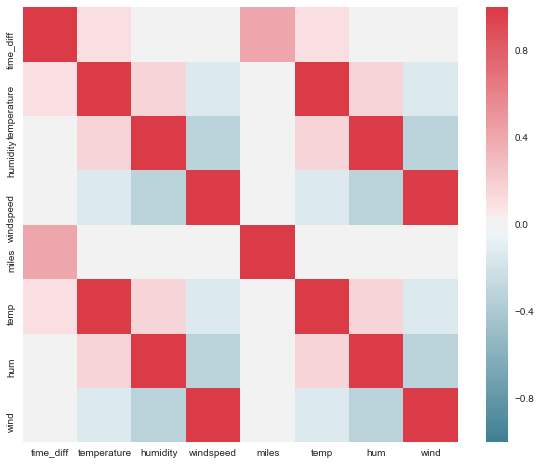

In [9]:
# Checking the correlations between continuous variables
corr = bikeshare_machine.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [10]:
# Turn categorical data into dummy variables. Dropping first dummy for the category variables that have 2 labels
bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['member_type','holiday','work_day'], drop_first=True)
# Turning categorical data into dummy variables. Not dropping the first dummy for categorical data with more
# than 2 labels
bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['start_station','end_station','season','month','weekday','weather_cat'])
bikeshare_machine.head()

,time_diff,temperature,humidity,windspeed,miles,temp,hum,wind,member_type_Registered,holiday_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cat_1,weather_cat_2,weather_cat_3
0,1.833,0.268333,0.918333,0.217646,0.238743,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
1,3.317,0.268333,0.918333,0.217646,0.659533,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
2,5.733,0.268333,0.918333,0.217646,0.691996,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
3,8.700,0.268333,0.918333,0.217646,1.453796,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
4,7.850,0.268333,0.918333,0.217646,1.351053,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1


In [11]:
bikeshare_machine = shuffle(bikeshare_machine)
bikeshare_machine.head()

,time_diff,temperature,humidity,windspeed,miles,temp,hum,wind,member_type_Registered,holiday_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cat_1,weather_cat_2,weather_cat_3
1170643,15.867,0.560833,0.807917,0.121271,1.493257,18.359151,80.7917,8.125157,1,0,...,0,0,1,0,0,0,0,1,0,0
719577,7.517,0.385833,0.595417,0.061571,1.073435,10.134151,59.5417,4.125244,1,0,...,0,0,1,0,0,0,0,0,1,0
52215,5.317,0.343478,0.680000,0.125248,0.300373,8.143466,68.0000,8.391616,1,0,...,1,0,0,0,0,0,0,1,0,0
620350,8.633,0.830000,0.550833,0.169171,0.495135,31.010000,55.0833,11.334457,1,0,...,1,0,0,0,0,0,0,1,0,0
1169775,10.233,0.560833,0.807917,0.121271,1.477771,18.359151,80.7917,8.125157,1,0,...,0,0,1,0,0,0,0,1,0,0


### Model 1 - Remove Some Variables that are correlated

In [12]:
# Leave workday, drop weekdays, leave season, drop month
# Workday overlaps with workday/not workday and months overlap with seasons
remove_cols = ['weekday_0', 'weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6', 
              'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9',
              'month_10','month_11','month_12','temperature','humidity','windspeed', 'time_diff']
X1 = np.matrix(bikeshare_machine.drop(remove_cols, 1))
y1 = bikeshare_machine['time_diff']

In [13]:
# Split the data into training and testing sets and check the shape
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.25, random_state=17)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((914885, 276), (304962, 276), (914885,), (304962,))

In [14]:
# Fit model
model1 = LinearRegression()
model1.fit(X1_train, y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
pred1 = model1.predict(X1_test)
cvscores_model1 = cross_val_score(model1, X1_train, y1_train, cv=5)
model1_r = model1.score(X1_test, y1_test)
model1_mse = mean_squared_error(y1_test, pred1)
model1_rmse = np.sqrt(model1_mse)
adjustedr1 = 1 - (1-model1_r)*(len(y1_test)-1)/(len(y1_test)-X1_test.shape[1]-1)

In [16]:
cvscores_model1, model1_r, adjustedr1, model1_mse, model1_rmse

(array([ 0.40907176,  0.40587554,  0.41857481,  0.41645462,  0.41218062]),
 0.41602117631079233,
 0.41549217699891872,
 79.579954173241077,
 8.9207597307203095)

In [17]:
model1_sm = sm.OLS(y1_train, X1_train).fit()
model1_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     2364.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:00:14   Log-Likelihood:            -3.3061e+06
No. Observations:              914885   AIC:                         6.613e+06
Df Residuals:                  914612   BIC:                         6.616e+06
Df Model:                         272                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.1419      0.013    458.118      0.000       6.116       6.168
x2             0.0565      0.002     28.626      0.000       0.053       0.060
x3             0.0004      0.001      0.433      0.665      -0.001       0.002
x4            -0.0076      0.002     -3.732      0.000      -0.012      -0.004
x5           -11.3609      0.027   -413.401      0.000     -11.415     -11.307
x6            -0.5051      0.065     -7.824      0.000      -0.632      -0.379
x7            -1.7249      0.022    -78.178      0.000      -1.768      -1.682
x8            -0.6150      0.218     -2.825      0.005      -1.042      -0.188
x9            -1.2194      0.113    -10.820      0.000      -1.440      -0.999
x10            3.4456      0.116     29.632      0.000       3.218       3.673
x11           -1.1553      0.246     -4.698      0.000      -1.637      -0.673
x12           -1.9664      0.117    -16.799      0.000      -2.196      -1.737
x13            1.4758      0.307      4.800      0.000       0.873       2.078
x14           -0.6235      0.318     -1.962      0.050      -1.246      -0.001
x15           -1.8272      0.124    -14.753      0.000      -2.070      -1.584
x16           -1.0610      0.125     -8.491      0.000      -1.306      -0.816
x17            0.3521      0.118      2.987      0.003       0.121       0.583
x18            3.3350      0.131     25.365      0.000       3.077       3.593
x19           -1.1724      0.138     -8.474      0.000      -1.444      -0.901
x20            1.2855      0.121     10.593      0.000       1.048       1.523
x21           -2.4324      0.111    -21.959      0.000      -2.650      -2.215
x22           -1.3650      0.113    -12.039      0.000      -1.587      -1.143
x23           -0.8588      0.106     -8.118      0.000      -1.066      -0.651
x24           -1.4589      0.103    -14.127      0.000      -1.661      -1.256
x25           -2.3932      0.140    -17.060      0.000      -2.668      -2.118
x26           -2.0944      0.223     -9.400      0.000      -2.531      -1.658
x27            2.9886      0.233     12.840      0.000       2.532       3.445
x28           -0.4944      0.100     -4.943      0.000      -0.690      -0.298
x29           -1.9006      0.282     -6.747      0.000      -2.453      -1.348
x30           -2.2768      0.109    -20.905      0.000      -2.490      -2.063
x31           -0.7412      0.102     -7.261      0.000      -0.941      -0.541
x32            0.1691      0.126      1.339      0.180      -0.078       0.416
x33           -0.4806      0.112     -4.286      0.000      -0.700      -0.261
x34           -0.1084      0.208     -0.521      0.602      -0.516       0.299
x35            1.2600      0.147      8.586      0.000       0.972       1.548
x36           -0.4975      0.192     -2.587      0.010      -0.874      -0.121
x3

### Model 2 - Try reverse of Model 1

In [18]:
# Drop workday, leave weekdays, drop season, leave month
# Workday overlaps with workday/not workday and months overlap with seasons
remove_cols = ['work_day_1','season_1', 'season_2', 'season_3', 'season_4',
               'temperature','humidity','windspeed', 'time_diff']
X2 = bikeshare_machine.drop(remove_cols, 1)
y2 = bikeshare_machine['time_diff']

In [19]:
# Split the data into training and testing sets and check the shape
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.25, random_state=17)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((914885, 290), (304962, 290), (914885,), (304962,))

In [20]:
# Fit model
model2 = LinearRegression()
model2.fit(X2_train, y2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
pred2 = model2.predict(X2_test)
cvscores_model2 = cross_val_score(model2, X2_train, y2_train, cv=5)
model2_r = model2.score(X2_test, y2_test)
model2_mse = mean_squared_error(y2_test, pred2)
model2_rmse = np.sqrt(model2_mse)
adjustedr2 = 1 - (1-model2_r)*(len(y2_test)-1)/(len(y2_test)-X2_test.shape[1]-1)

In [22]:
cvscores_model2, model2_r, adjustedr2, model2_mse, model2_rmse

(array([ 0.40979736,  0.40644948,  0.41908005,  0.41705633,  0.41290611]),
 0.41670644395226281,
 0.41615123807033161,
 79.486571390694081,
 8.9155241792445423)

In [23]:
# Use statsmodel to check the statistical side of the model
model2_sm = sm.OLS(y2_train, X2_train).fit()
model2_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     2262.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:02:23   Log-Likelihood:            -3.3056e+06
No. Observations:              914885   AIC:                         6.612e+06
Df Residuals:                  914599   BIC:                         6.615e+06
Df Model:                         285                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
miles                                                                 6.1373      0.013    457.906      0.000       6.111       6.164
temp                                                                  0.0602      0.003     21.086      0.000       0.055       0.066
hum                                                                  -0.0046      0.001     -4.521      0.000      -0.007      -0.003
wind                                                                 -0.0173      0.002     -8.266      0.000      -0.021      -0.013
member_type_Registered                                              -11.3306      0.027   -412.078      0.000     -11.385     -11.277
holiday_1                                                             1.0594      0.066     16.007      0.000       0.930       1.189
start_station_10th & Monroe St NE                                    -0.6374      0.218     -2.930      0.003      -1.064      -0.211
start_station_10th & U St NW                                         -1.2436      0.113    -11.041      0.000      -1.464      -1.023
start_station_10th St & Constitution Ave NW                           3.4104      0.116     29.349      0.000       3.183       3.638
start_station_11th & H St NE                                         -1.1021      0.246     -4.483      0.000      -1.584      -0.620
start_station_11th & Kenyon St NW                                    -1.9768      0.117    -16.899      0.000      -2.206      -1.748
start_station_12th & Army Navy Dr                                     1.4566      0.307      4.740      0.000       0.854       2.059
start_station_12th & Newton St NE                                    -0.6650      0.318     -2.094      0.036      -1.287      -0.043
start_station_13th & D St NE                                         -1.8443      0.124    -14.900      0.000      -2.087      -1.602
start_station_13th & H St NE                                         -1.0912      0.125     -8.738      0.000      -1.336      -0.846
start_station_13th St & New York Ave NW                               0.3235      0.118      2.746      0.006       0.093       0.554
start_station_14th & D St NW / Ronald Reagan Building                 3.3230      0.131     25.290      0.000       3.066       3.581
start_station_14th & D St SE                                         -1.1881      0.138     -8.593      0.000      -1.459      -0.917
start_station_14th & G St NW                                          1.2564      0.121     10.360      0.000       1.019       1.494
start_station_14th & Harvard St NW                                   -2.4515      0.111    -22.145      0.000      -2.668      -2.235
s

### Model 3 - All variables

In [24]:
# Keep all but time_diff
X3 = bikeshare_machine.drop('time_diff', 1)
y3 = bikeshare_machine['time_diff']

In [25]:
# Split the data into training and testing sets and check the shape
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.25, random_state=17)
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((914885, 298), (304962, 298), (914885,), (304962,))

In [26]:
# Fit model
model3 = LinearRegression()
model3.fit(X3_train, y3_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
pred3 = model3.predict(X3_test)
cvscores_model3 = cross_val_score(model3, X3_train, y3_train, cv=5)
model3_r = model3.score(X3_test, y3_test)
model3_mse = mean_squared_error(y3_test, pred3)
model3_rmse = np.sqrt(model3_mse)
adjustedr3 = 1 - (1-model3_r)*(len(y3_test)-1)/(len(y3_test)-X3_test.shape[1]-1)

In [28]:
cvscores_model3, model3_r, adjustedr3, model3_mse, model3_rmse

(array([  4.09810506e-01,   4.06447214e-01,   4.19087048e-01,
         -1.19518209e+12,   4.12928304e-01]),
 0.41671251479452454,
 0.4161419838452749,
 79.485744104961469,
 8.9154777833249899)

In [29]:
# Use statsmodel to check the statistical side of the model
model3_sm = sm.OLS(y3_train, X3_train).fit()
model3_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     2239.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:04:39   Log-Likelihood:            -3.3056e+06
No. Observations:              914885   AIC:                         6.612e+06
Df Residuals:                  914596   BIC:                         6.615e+06
Df Model:                         288                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
temperature                                                           2.9831      0.023    127.402      0.000       2.937       3.029
humidity                                                          -4.604e-05   1.01e-05     -4.538      0.000   -6.59e-05   -2.62e-05
windspeed                                                            -0.0003   3.13e-05     -8.383      0.000      -0.000      -0.000
miles                                                                 6.1374      0.013    457.919      0.000       6.111       6.164
temp                                                                 -0.0035      0.003     -1.162      0.245      -0.009       0.002
hum                                                                  -0.0046      0.001     -4.538      0.000      -0.007      -0.003
wind                                                                 -0.0176      0.002     -8.383      0.000      -0.022      -0.013
member_type_Registered                                              -11.3302      0.027   -412.019      0.000     -11.384     -11.276
holiday_1                                                             3.6807      0.056     65.338      0.000       3.570       3.791
work_day_1                                                            2.6270      0.035     74.158      0.000       2.558       2.696
start_station_10th & Monroe St NE                                    -0.7282      0.218     -3.345      0.001      -1.155      -0.302
start_station_10th & U St NW                                         -1.3338      0.113    -11.812      0.000      -1.555      -1.113
start_station_10th St & Constitution Ave NW                           3.3197      0.116     28.498      0.000       3.091       3.548
start_station_11th & H St NE                                         -1.1931      0.246     -4.850      0.000      -1.675      -0.711
start_station_11th & Kenyon St NW                                    -2.0679      0.117    -17.636      0.000      -2.298      -1.838
start_station_12th & Army Navy Dr                                     1.3649      0.307      4.440      0.000       0.762       1.967
start_station_12th & Newton St NE                                    -0.7590      0.318     -2.389      0.017      -1.382      -0.136
start_station_13th & D St NE                                         -1.9350      0.124    -15.600      0.000      -2.178      -1.692
start_station_13th & H St NE                                         -1.1820      0.125     -9.445      0.000      -1.427      -0.937
start_station_13th St & New York Ave NW                               0.2321      0.118      1.966      0.049       0.001       0.463
s

### Model 4 - Ridge with Round 1

In [30]:
# Fit the model with 5 folds
alpha = np.arange(0.0001, 20, 25)
param_grid = {'alpha': alpha}
ridge1 = Ridge(fit_intercept=True)
ridge1_gs = GridSearchCV(ridge1, param_grid, cv=5)
ridge1_gs.fit(X1_train, y1_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.0001])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [31]:
pred4 = ridge1_gs.predict(X1_test)
ridge1_r = ridge1_gs.score(X1_test, y1_test)
ridge1_mse = mean_squared_error(y1_test, pred4)
ridge1_rmse = np.sqrt(ridge1_mse)
adjustedr4 = 1 - (1-ridge1_r)*(len(y1_test)-1)/(len(y1_test)-X1_test.shape[1]-1)

In [32]:
ridge1_r, ridge1_mse, ridge1_rmse, adjustedr4

(0.41602113781062394,
 79.579959419735502,
 8.9207600247812682,
 0.41549213846387489)

### Ridge with Round 2

In [33]:
# Fit the model with 5 folds
alpha = np.arange(0.0001, 20, 25)
param_grid = {'alpha': alpha}
ridge2 = Ridge(fit_intercept=True)
ridge2_gs = GridSearchCV(ridge2, param_grid, cv=5)
ridge2_gs.fit(X2_train, y2_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.0001])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [34]:
pred5 = ridge2_gs.predict(X2_test)
ridge2_r = ridge2_gs.score(X2_test, y2_test)
ridge2_mse = mean_squared_error(y2_test, pred5)
ridge2_rmse = np.sqrt(ridge2_mse)
adjustedr5 = 1 - (1-ridge2_r)*(len(y2_test)-1)/(len(y2_test)-X2_test.shape[1]-1)

In [35]:
ridge2_r, ridge2_mse, ridge2_rmse, adjustedr5

(0.41670644519114719,
 79.486571221868843,
 8.9155241697764946,
 0.41615123931039522)

### Ridge with all data

In [36]:
# Fit the model with 5 folds
alpha = np.arange(0.0001, 20, 25)
param_grid = {'alpha': alpha}
ridge3 = Ridge(fit_intercept=True)
ridge3_gs = GridSearchCV(ridge3, param_grid, cv=5)
ridge3_gs.fit(X3_train, y3_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.0001])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [37]:
pred6 = ridge3_gs.predict(X3_test)
ridge3_r = ridge3_gs.score(X3_test, y3_test)
ridge3_mse = mean_squared_error(y3_test, pred6)
ridge3_rmse = np.sqrt(ridge3_mse)
adjustedr6 = 1 - (1-ridge3_r)*(len(y3_test)-1)/(len(y3_test)-X3_test.shape[1]-1)

In [38]:
ridge3_r, ridge3_mse, ridge3_rmse, adjustedr6

(0.41671258675169731,
 79.485734299214627,
 8.9154772333966861,
 0.41614205587283115)

In [39]:
bikeshare_machine.to_csv('machine_full.csv')